# 基于UNET网络实现SEA_ICE数据语义分割    
模型读取和分割 

In [11]:

import os,gc
#os.environ['CUDA_VISIBLE_DEVICES']="0,1"
import cv2
import tqdm
import torch
import numpy as np
import torch.nn as nn
from skimage import io
import torch.nn.functional as F
from torch.hub import load_state_dict_from_url
from torch import optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
from sklearn.metrics import f1_score, precision_score, recall_score

transform = transforms.Compose([
    transforms.ToTensor()
])

In [12]:
# # 统一图片大小
def keep_image_size_open(path, size=(256, 256)):
    img = Image.open(path)
    temp = max(img.size)
    mask = Image.new('RGB', (temp, temp))  #补为方图
    mask.paste(img, (0, 0))
    mask = mask.resize(size)              #重采样
    return mask

def keep_label_size_open(path, size=(256, 256)):
    img = Image.open(path)
    label = np.array(img) 
    label =label /255
    label[label > 0.5] = 255
    label[label < 0.5] = 0
    label=  np.expand_dims(label,-1)
    print(f'qww{label.shape}')
    return label

#数据读取方法
class MyDataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.name = os.listdir(os.path.join(path, 'label'))  #得到文件名

    def __len__(self):
        return len(self.name)

    def __getitem__(self, index):
        segment_name = self.name[index]  
        label_path = os.path.join(self.path, 'label', segment_name)
        image_path = os.path.join(self.path, 'image', segment_name)
        
        label = keep_label_size_open(label_path)
        image = keep_image_size_open(image_path)
        
        
        image = transform(image)
        label = transform(label)
        return image, label

    
def train_test_dataset(full_dataset, p):
    assert p > 0 and p < 1  
    train_size = int(p * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    return train_dataset, test_dataset

In [13]:
def plt_predict(per, label):
    per = torch.squeeze(per, dim=0)
    per = torch.squeeze(per, dim=0)
    per = per.cpu().detach().numpy()
    #per = per /255
    per[per > 0.5] = 255
    per[per < 0.5] = 0
    
    label = torch.squeeze(label, dim=0)
    labal = label.cpu().detach().numpy()
    
    plt.subplot(1,2,1)
    plt.imshow(per)
    plt.subplot(1,2,2)
    plt.imshow(label)
    plt.show()
    

In [14]:
class Conv_Block(nn.Module):       #卷积块，包括两层卷积，两个RELU，两个BN
    def __init__(self,in_channel,out_channel):
        super(Conv_Block, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(in_channel,out_channel,3,1,1,padding_mode='reflect',bias=False),   #若使用BN，则不要有bias 
            nn.BatchNorm2d(out_channel),
            nn.Dropout2d(0.3),
            nn.LeakyReLU(),
            nn.Conv2d(out_channel, out_channel, 3, 1, 1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(out_channel),
            nn.Dropout2d(0.3),
            nn.LeakyReLU()
        )
        
    def forward(self,x):
        return self.layer(x)


class DownSample(nn.Module):         #下采样
    def __init__(self,channel):
        super(DownSample, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(channel,channel,3,2,1,padding_mode='reflect',bias=False),
            #nn.MaxPool2d(channel,channel,3,2,1,padding_mode='reflect',bias=False),  #Z最大池化可能会丢失信息
            nn.BatchNorm2d(channel),
            nn.LeakyReLU()
        )
    def forward(self,x):
        return self.layer(x)


class UpSample(nn.Module):       # 上采样
    def __init__(self,channel):
        super(UpSample, self).__init__()
        self.layer=nn.Conv2d(channel,channel//2,1,1)       #通道压缩
    def forward(self,x,feature_map):                        
        up=F.interpolate(x,scale_factor=2,mode='nearest')  #使用最邻近插值法，扩大两倍
        out=self.layer(up)
        return torch.cat((out,feature_map),dim=1)          #与前面得特征层做堆叠（N,C,H,W）


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.c1=Conv_Block(3,64)
        self.d1=DownSample(64)
        self.c2=Conv_Block(64,128)
        self.d2=DownSample(128)
        self.c3=Conv_Block(128,256)
        self.d3=DownSample(256)
        self.c4=Conv_Block(256,512)
        self.d4=DownSample(512)
        self.c5=Conv_Block(512,1024)
        self.u1=UpSample(1024)
        self.c6=Conv_Block(1024,512)
        self.u2 = UpSample(512)
        self.c7 = Conv_Block(512, 256)
        self.u3 = UpSample(256)
        self.c8 = Conv_Block(256, 128)
        self.u4 = UpSample(128)
        self.c9 = Conv_Block(128, 64)
        self.out=nn.Conv2d(64,1,3,1,1)

    def forward(self,x):
        #主干特征提取
        R1=self.c1(x)
        R2=self.c2(self.d1(R1))
        R3 = self.c3(self.d2(R2))
        R4 = self.c4(self.d3(R3))
        R5 = self.c5(self.d4(R4))
        
        #加强特征提取
        O1=self.c6(self.u1(R5,R4))
        O2 = self.c7(self.u2(O1, R3))
        O3 = self.c8(self.u3(O2, R2))
        O4 = self.c9(self.u4(O3, R1))

        return self.out(O4)

* 读取权重并预测

successfully
qww(256, 256, 1)


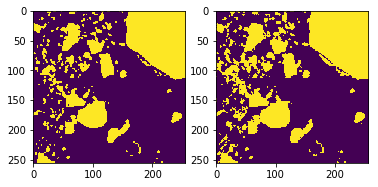

qww(256, 256, 1)


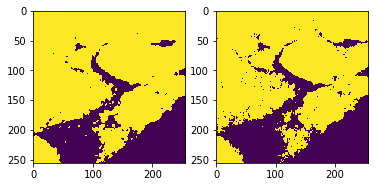

qww(256, 256, 1)


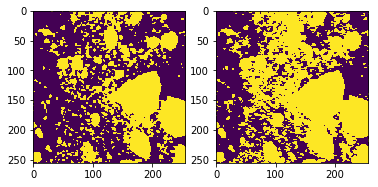

qww(256, 256, 1)


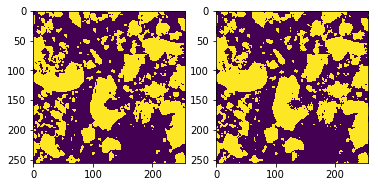

qww(256, 256, 1)


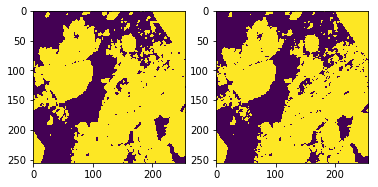

In [15]:
if __name__ == '__main__':
    data_path =r'./sea_ice'
    weight_path = os.path.join(data_path,'unet_1.pth')
    save_path = 'train_image'
    net = UNet()

    if os.path.exists(weight_path):
        net.load_state_dict(torch.load(weight_path))
        print('successfully')
    else:
        print('no loading')
    

    data_set =MyDataset(data_path)
    
    net.eval()
    for i in range(5):
        img, label = data_set[i] 
        img =img.unsqueeze(0)
        per_label = net(img)
        plt_predict(per_label, label)
        
